In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import joblib
import os
import warnings
warnings.filterwarnings('ignore')  
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文  

# 设置Seaborn样式
sns.set(font='Microsoft YaHei')


In [2]:
output_file = 'output/TN_NH3_N2O' # 输出文件夹
input_file = 'data/TN_NH3_N2O' # 输入数据文件夹
os.makedirs(output_file, exist_ok=True)

def set_filename(target):
    model_save_file = f'{output_file}/model_{target}' # 模型参数文件夹
    
    os.makedirs(model_save_file, exist_ok=True)
    data_path = f'{input_file}/data_for_{target}.csv'
    model_performance_path = f'{model_save_file}/Model_{target}.html'
    mse_json = f'{model_save_file}/result_mse_{target}.json'
    mae_json = f'{model_save_file}/result_mae_{target}.json'
    r2_json = f'{model_save_file}/result_r2_{target}.json'

    return data_path, model_performance_path, mse_json, mae_json, r2_json, model_save_file

In [3]:
targets = ['TN loss (%)', 'NH3-N loss (%)', 'N2O-N loss (%)', 'TC loss (%)', 'CH4-C loss (%)', 'CO2-C loss (%)']

# 设置日志
from utils import set_logger
import logging
log_path = output_file + f"/train.log" # 日志路径
# 设置日志和种子数
os.makedirs(os.path.dirname(log_path), exist_ok=True)
set_logger(log_path)

In [4]:
# 为了正确评估模型性能，将数据划分为训练集和测试集，并在训练集上训练模型，在测试集上验证模型性能。
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True)

#### 数据集划分

In [10]:
def get_data(data_path):
    data_all_ef = pd.read_csv(data_path)
    X_all = data_all_ef.iloc[:, :-1]
    y_all = data_all_ef.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=2023)
    y_train = y_train.reset_index(drop=True)
    input_cols = X_all.columns.tolist()
    return X_train, X_test, y_train, y_test, input_cols

In [6]:
from models import ModelBase, RFTraining, LGBTraining, XGBTraining, CatTraining, LRTraining, \
                RidgeTraining, MLPTraining, SVRTraining, GSRTraining

In [7]:
models = {'rf': RFTraining,
          'xgb': XGBTraining,
          'lgb': LGBTraining,
          'cat': CatTraining,
          'lr': LRTraining,
          'ridgelr': RidgeTraining,
          'mlp': MLPTraining,
          'svr': SVRTraining,
          'gsr': GSRTraining}

use_models = ['rf', 'xgb', 'lgb', 'cat', 'lr', 'ridgelr', 'mlp', 'svr', 'gsr']

In [8]:
# 模型预测
import json

for target in targets:
    # 获取字典保存各个模型的最终结果
    logging.info('{} Prediction Training--------------------------------------------------------------------------------------'.format(target))
    result_mse = {}
    result_r2 = {}
    result_mae = {}
    data_path, model_performance_path, mse_json, mae_json, r2_json, model_save_file = set_filename(target)
    X_train, X_test, y_train, y_test, input_cols = get_data(data_path)
    for model_name in use_models:
        model: ModelBase = models[model_name](X_train, y_train, X_test, y_test, \
                                        kf, model_save_file, target, method=model_name)
        model.train()
        mse, mae, r2, pred = model.test()
        model.save_result()
        if model_name in ['rf', 'xgb', 'lgb', 'cat']:
            model.get_important_analyse()

        result_mse[f'{model_name}(k)'] = metrics.mean_squared_error(y_test,pred)
        result_mae[f'{model_name}(k)'] = metrics.mean_absolute_error(y_test,pred)
        result_r2[f'{model_name}(k)'] = metrics.r2_score(y_test,pred)
    
    # 将字典保存为 JSON 文件
    with open(mse_json, 'w') as json_file:
        json.dump(result_mse, json_file)
    with open(mae_json, 'w') as json_file:
        json.dump(result_mae, json_file)
    with open(r2_json, 'w') as json_file:
        json.dump(result_r2, json_file)


save ok-----------
save ok-----------
save ok-----------
save ok-----------
save ok...
save ok...
save ok...
save ok...
save ok...
save ok-----------
save ok-----------
save ok-----------
save ok-----------
save ok...
save ok...
save ok...
save ok...
save ok...
save ok-----------
save ok-----------
save ok-----------
save ok-----------
save ok...
save ok...
save ok...
save ok...
save ok...
save ok-----------
save ok-----------
save ok-----------
save ok-----------
save ok...
save ok...
save ok...
save ok...
save ok...
save ok-----------
save ok-----------
save ok-----------
save ok-----------
save ok...
save ok...
save ok...
save ok...
save ok...
save ok-----------
save ok-----------
save ok-----------
save ok-----------
save ok...
save ok...
save ok...
save ok...
save ok...


### 不同模型的效果比对分析（RMSE指标）

In [25]:
import plotly.express as px
import plotly.io as pio

with open(r2_json, 'r') as json_file:
    result_mse = json.load(json_file)
    
result_mse = dict(sorted(result_mse.items(), key=lambda item: item[1]))
categories = list(result_mse.keys())
values = list(result_mse.values())

color_mapping = {}
for k, v in result_mse.items():
    if v < 0.4:
        color_mapping[k] = "Tree-Base"
    else:
        color_mapping[k] = "Other"
    
# 创建柱状图
fig = px.bar(x=categories, y=values, title=f'Models Performance in {target}', color=color_mapping)
fig.update_layout(template="seaborn")
# 显示图表
fig.show()
# 保存柱状图为 HTML 文件
pio.write_html(fig, file=model_performance_path)  

### 挑选合适的模型进行进一步的变量分析(Tree-Base)

In [12]:
import shap
shap.initjs()

target = 'CO2-C loss (%)'
method = 'lgb'
model_path = f'{model_save_file}/{method}/{method}_model.pkl'

from lightgbm import LGBMRegressor
lgb_model = LGBMRegressor(objective='regression', 
                          num_leaves=31, 
                          learning_rate=0.05, 
                          n_estimators=20)
lgb_model = joblib.load(model_path)

### SHAP值分析（LGB为例）

SHAP是由Shapley value启发的可加性解释模型。对于每个预测样本，模型都产生一个预测值，SHAP value就是该样本中每个特征所分配到的数值。 
很明显可以看出，与上一节中feature importance相比，SHAP value最大的优势是SHAP能对于反映出每一个样本中的特征的影响力，而且还表现出影响的正负性。

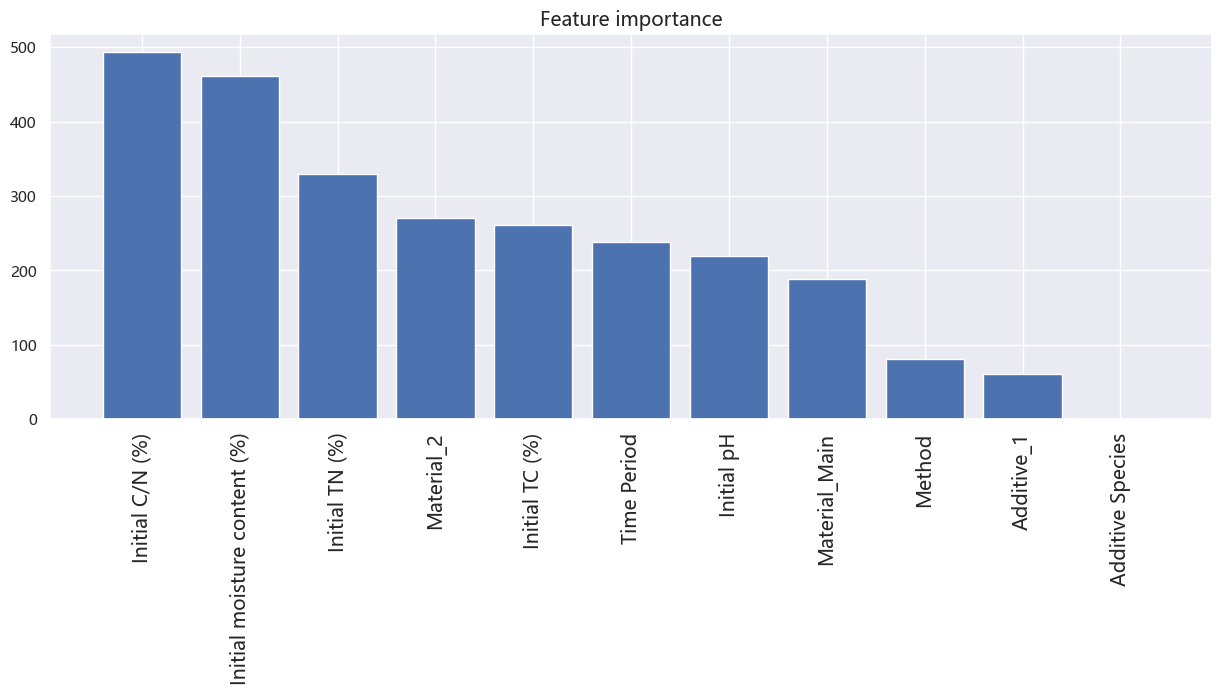

In [13]:
# 获取feature importance
plt.figure(figsize=(15, 5))

feat_importance=pd.DataFrame()
feat_importance["Importance"]=lgb_model.feature_importances_
feat_importance.set_index(X_train.columns, inplace=True)

feat_importance = feat_importance.sort_values(by='Importance', ascending=False)

plt.bar(range(len(X_train.columns)), feat_importance['Importance'])
plt.xticks(range(len(X_train.columns)), feat_importance.index, rotation=90, fontsize=14)
plt.title('Feature importance', fontsize=14)
plt.show()

In [14]:
lgb_explainer = shap.TreeExplainer(lgb_model)
lgb_shap_values = lgb_explainer.shap_values(X_train)
print(lgb_shap_values.shape)

(157, 11)


In [15]:
shap.force_plot(lgb_explainer.expected_value, lgb_shap_values[0,:], X_train.iloc[0,:])

对第一个实例的特征贡献图也可用 waterfall 方式展示

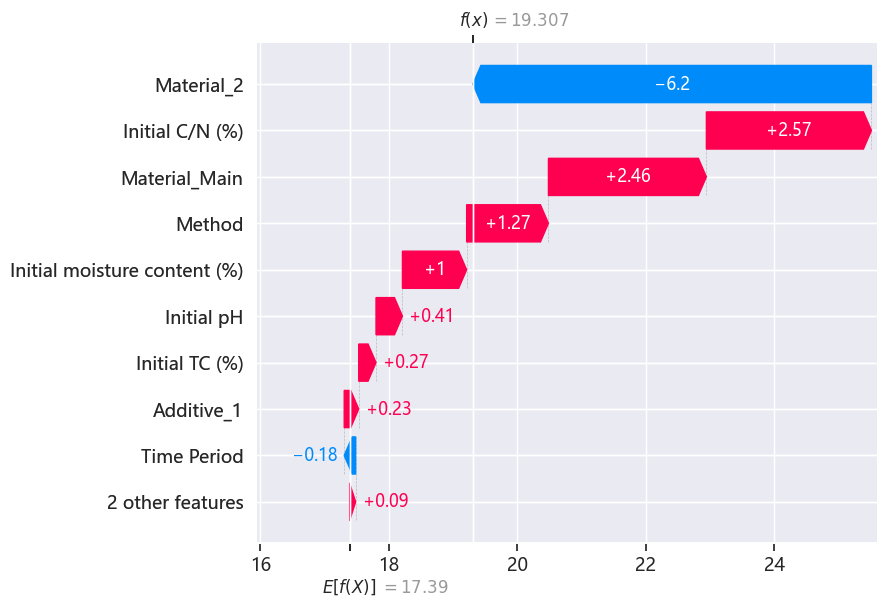

In [16]:
shap.plots._waterfall.waterfall_legacy(
    lgb_explainer.expected_value, 
    lgb_shap_values[0], 
    feature_names=X_train.columns)

上图的解释显示了每个有助于将模型输出从基值（我们传递的训练数据集上的平均模型输出）贡献到模型输出值的特征。将预测推高的特征以红色显示，将预测推低的特征以蓝色显示。

如果我们采取许多实例来聚合显示解释，如下图所示，将它们旋转 90 度，然后将它们水平堆叠，我们可以看到整个数据集的解释（在 Notebook 中，此图是交互式的）

In [17]:
# visualize the training set predictions
shap.force_plot(lgb_explainer.expected_value, lgb_shap_values, X_train)

下图中每一行代表一个特征，横坐标为SHAP值。一个点代表一个样本，颜色越红说明特征本身数值越大，颜色越蓝说明特征本身数值越小。

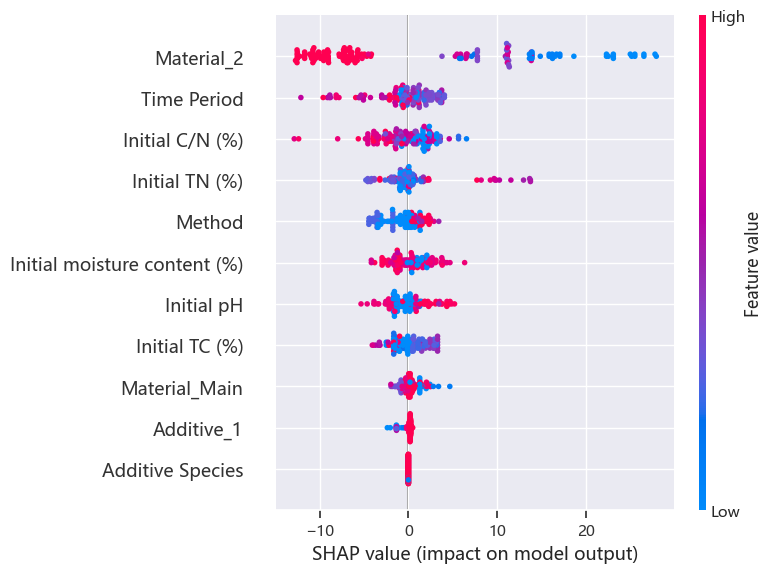

In [18]:
shap.summary_plot(lgb_shap_values, X_train)

shap value值排序的特征重要性

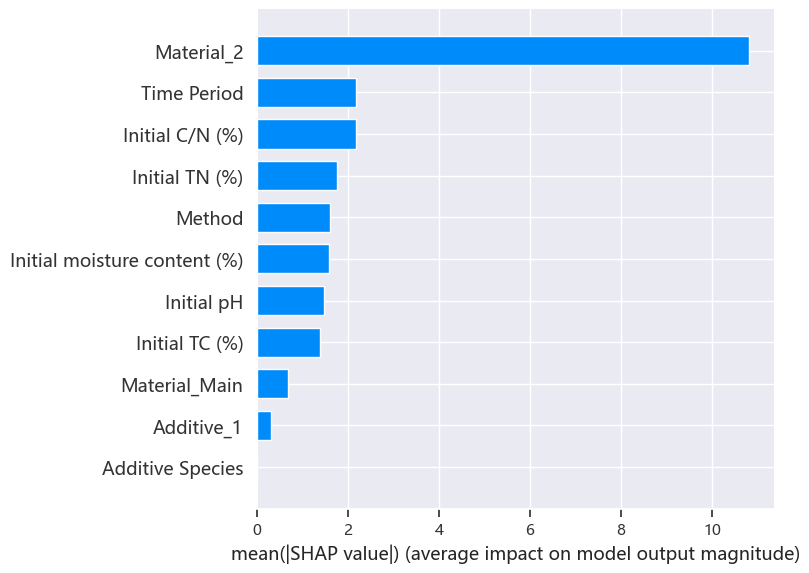

In [19]:
shap.summary_plot(lgb_shap_values, X_train, plot_type="bar")

SHAP也提供了部分依赖图的功能，与传统的部分依赖图不同的是，这里纵坐标不是目标变量y的数值而是SHAP值。可以观察各个特征的分布与目标shap值的关系。

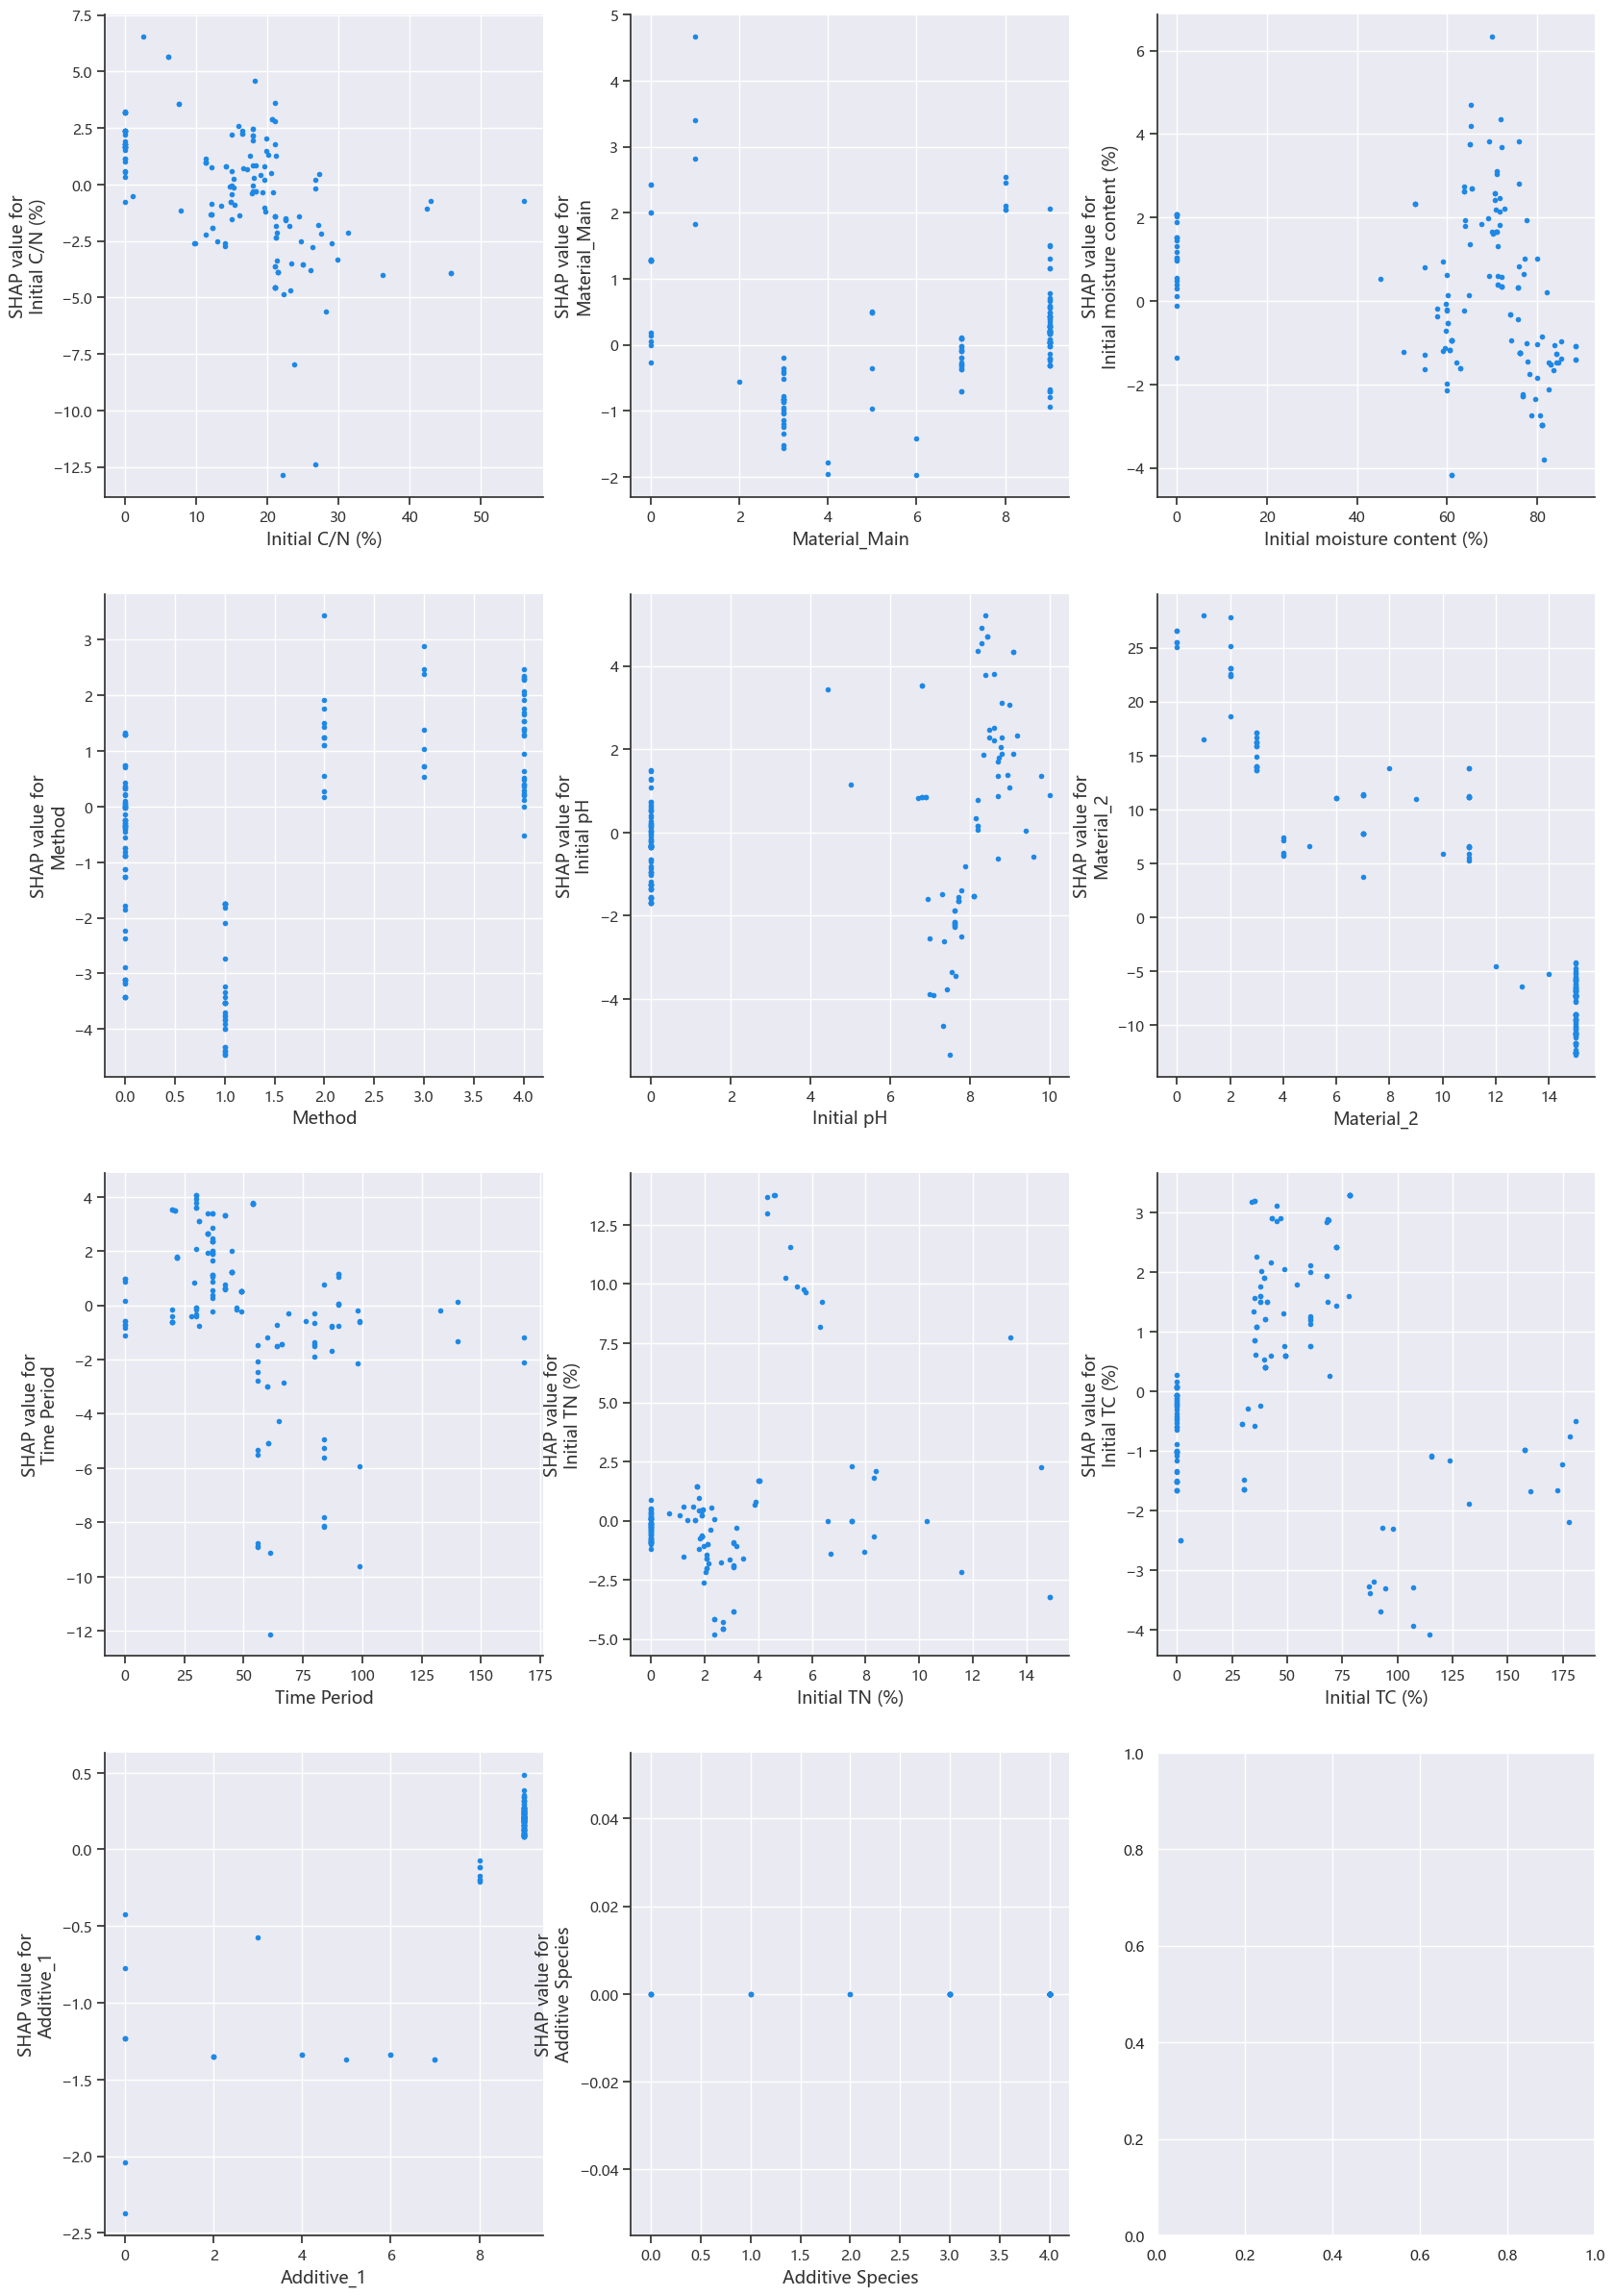

In [20]:
fig, axes = plt.subplots(len(input_cols)//3+1, 3, figsize=(20,30))
for i, col in enumerate(input_cols):
    shap.dependence_plot(col, lgb_shap_values, X_train, interaction_index=None, show=False, ax=axes[i//3,i%3])
    

- 对多个变量的交互进行分析

我们也可以多个变量的交互作用进行分析。一种方式是采用summary_plot描绘出散点图，如下：

<Figure size 1200x1200 with 0 Axes>

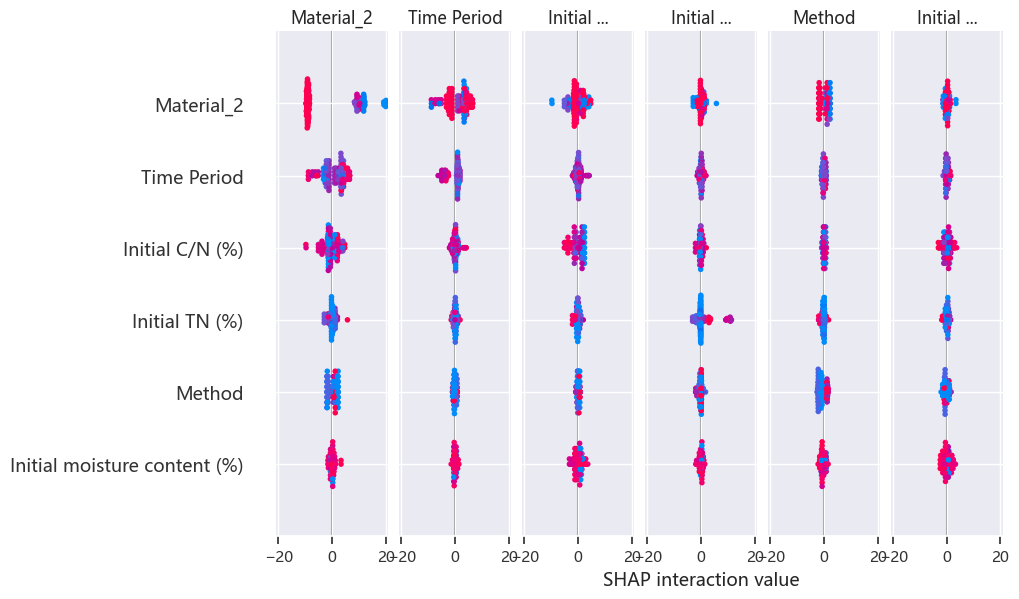

In [21]:
shap_interaction_values = shap.TreeExplainer(lgb_model).shap_interaction_values(X_train)
plt.figure(figsize=(12,12))
shap.summary_plot(shap_interaction_values, X_train, max_display=6)
plt.show()

我们也可以用dependence_plot描绘两个变量交互下变量对目标值的影响。

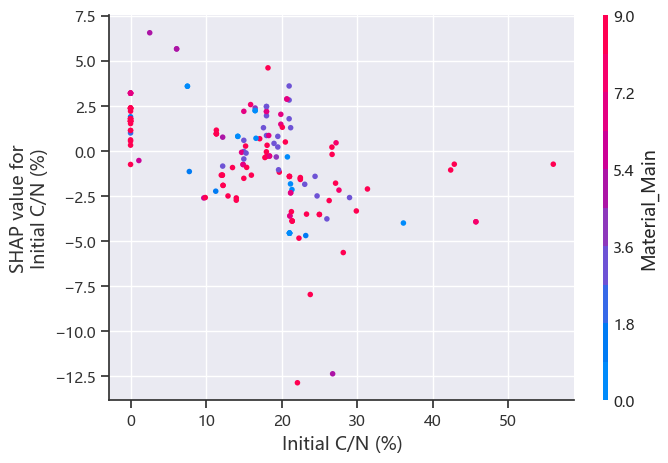

In [22]:
shap.dependence_plot(input_cols[0], lgb_shap_values, X_train, interaction_index=input_cols[1], show=False)

也能可视化每种特征对于整体预测值的影响。

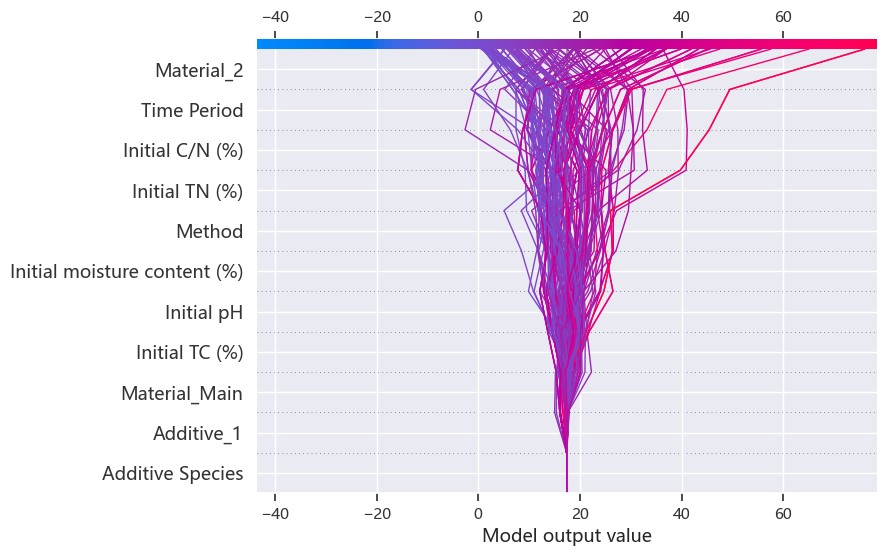

In [23]:
shap.decision_plot(lgb_explainer.expected_value, lgb_shap_values, X_train, ignore_warnings=True)

In [24]:
logging.info(' ')